In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/Shareddrives/vae-asr/

Mounted at /content/drive
/content/drive/Shareddrives/vae-asr


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import sys
sys.path.append('/content/drive/Shareddrives/vae-asr/modules')
from model import VAE
# help(VAE)
from data import MSA_Dataset
# help(MSA_Dataset)

## Run script to pre-process the VAE

Query sequence for PF00565_full: SND1_HUMAN/552-660

Query sequence for PF00041_full: TENA_HUMAN/804-884 (this is the same choice as original paper: https://github.com/BrooksResearchGroup-UM/PEVAE_Paper/blob/master/pfam_msa/script/proc_msa.py)

Query sequence for PF00067_full: A0A8J5V3X2_ZIZPA/310-424 (chosen for its sparsity so that eliminating sequences that have too many gaps where the query sequence has a letter does not result in very few remaining sequences)



In [3]:
MSA_id = "PF00067_full"
query_seq_id = "A0A8J5V3X2_ZIZPA/310-424"

In [ ]:
# !grep {query_seq_id} data/pevae_real/{MSA_id}.txt

The script writes the processed MSA objects as `.pkl` files in the `output/` directory.

In [ ]:
! python scripts/proc_msa.py data/pevae_real/{MSA_id}.txt {query_seq_id}

# of sequences in raw MSA: 17984


Check resulting processed MSA

In [ ]:
#Number of sequences
! wc -l ./output/{MSA_id}/seq_msa_char.txt

9767 ./output/PF00067_full/seq_msa_char.txt


In [4]:
#First few sequences
!head -n 25 ./output/PF00067_full/seq_msa_char.txt | awk '{print $2}'

RVHKEIDEVIGPDRPPMMEDRVKMPYTDAVVHEVQRSMDLAPAVPHKVMRDTEFHNYHIPEGTLVLPLISSVLADPQLWKNPNHFDPENFLDDAGHFQKNDAYECY.
KILQEIKTNLPRTSDSMQYYLNKLVYLRGALYEAMRLYPPVPERMSPI.NPDKLPSHKVDASMKILIFIYALGRMEAVWEDALEFKPERWVSKTGIEEPSYKRMKHG
KAQEEIRASLGTKGKVEEEDLHQLQYLKSVVKETWRLHSPAPLLPRESVRHSRIHGYDILPNTRVYVNAWGIAKDPKSWDDPEEFIPERFMDGPIDYGHNFELHLV.
KVKKELTDVVGLDRTVEEFHLPNLRYLNAVIKETFRLHPALPLVPRCSGKSITVGGYTIPKGSRVFLNIWSIHRDPHIWDNPLQFQPDRFLNDPDDYGSDFRLLI..
KAVDELDMVVGKERLVEESDIHSLTYLKACIREAFRIHPYHPNPSHVAIADITIAGFMIPKGSHIILSRIGLGRNPRAWDNPLEFRPERHLKNTNLVEPELRLLMQA
RLASEIRSTFSSRCIRAGHELHNCKYLRAVIDETMRMSPSSLPAWRS.QDVFTVDGHVIPPGTQVGSSRYAVQHNEAFFPEPFKFQPERWLSSEDARAMRRAAGNLG
RCREEVQMLLREREEIEWEDLSQLPFLTMCIKESLRLHPPVTVISRCTTQDVVLPDRVIPKGNICTISIFGIHHNPSVWPEPEVYNPFRFDPETPQKRSPLARAEEG
KLSLELERAELSGAVVSSEQAQNLAYLRACIREALRFAPTVSQLPRLAPRDTELHGEHVPPGYSVSTSPWVLGRSERLYPDAHVYRPERWLEAAEEQYWDRNAEVRS
RLAAEVDSARRQSTIIPADLCDRLPFLDAVVKETLRLYAPIPSQPRTSTRDMTVDGHLIPAGTVVSCQAYSLHRNPDVFRHPYKFNPDRWLAGDAEVEMRRWPTATS
KARSEINHNVQG.RLLDDSDLAKLPYLH

## Load data and instantiate dataset

In [5]:
## read multiple sequence alignment in binary representation
with open(f"./output/{MSA_id}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_seq = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([9767, 107, 21])

In [6]:
## each sequence has a label
with open(f"./output/{MSA_id}/keys_list.pkl", 'rb') as file_handle:
    msa_keys = pickle.load(file_handle)
msa_keys[:10]

['A0A8C4CNX3_9TELE/41-498',
 'A0A6D2KQW5_9BRAS/30-513',
 'A0A8K0MXP5_COCNU/37-492',
 'A0A6P5YD73_DURZI/55-522',
 'A0A0D3FSJ4_9ORYZ/51-514',
 'A0A2V1DIY2_9PLEO/30-468',
 'A0A8J6AVG1_GALPY/899-1088',
 'A0A168DGB0_CORFA/1-418',
 'A0A8H6P498_9EURO/256-505',
 'A0A7J6X3X1_THATH/28-493']

In [7]:
## sequences in msa are weighted
with open(f"./output/{MSA_id}/seq_weight.pkl", 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)
seq_weight[:10]

array([1.3613485e-04, 2.0739369e-04, 8.0609527e-05, 5.5940869e-05,
       1.0388179e-04, 1.8525257e-04, 5.8904512e-05, 1.3547979e-04,
       7.5113967e-05, 6.1428691e-05], dtype=float32)

In [8]:
data = MSA_Dataset(msa_binary, seq_weight, msa_keys)
# Show a random sample
data[100]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 0.00010963139,
 'A0A0L1IWY7_ASPNO/723-1184')

We see that an item of the dataset contains the one-hot representation of the sequence, the weight assigned to the sequence (explained later), and the name of the sequence

## Instantiate model

In [9]:
# For architecture hyper-parameters, we rely on the defaults in the class definition
model = VAE(nl = nl, nc = nc)

Let's check that our model processes data the way we want it to

In [10]:
#Encoding
one_hot_ary = data[100][0]
batch_one_hot_ary = torch.unsqueeze(one_hot_ary, 0)
latent_parameters = model.encoder(batch_one_hot_ary)
print(f"Mean and variance of latent vector:")
print(latent_parameters)
#Decoding
mn_z = latent_parameters[0]
recon_log_probs = model.decoder(mn_z)
print(f"Decoded output has shape {recon_log_probs.shape} and is given by:")
print(recon_log_probs)
probs = torch.exp(recon_log_probs.squeeze())
print("The probability for each amino acid in each position is:")
print(probs)
print("Rows should sum to 1: ")
print(torch.sum(probs, dim = 1))

Mean and variance of latent vector:
(tensor([[-0.0527, -0.0751,  0.0152,  0.0453,  0.0385,  0.0269, -0.0496,  0.0290,
          0.0537, -0.0373]], grad_fn=<AddmmBackward0>), tensor([[1.0361, 1.0326, 0.9614, 1.0208, 0.9312, 0.9865, 0.9874, 1.0559, 1.0398,
         0.9403]], grad_fn=<ExpBackward0>))
Decoded output has shape torch.Size([1, 107, 21]) and is given by:
tensor([[[-3.0824, -3.0549, -3.0310,  ..., -3.0695, -3.0602, -2.9696],
         [-3.0324, -3.0406, -2.9755,  ..., -3.0392, -3.0747, -3.0012],
         [-2.9559, -3.0641, -3.0779,  ..., -3.0183, -3.1161, -3.1453],
         ...,
         [-3.0220, -2.9869, -3.0441,  ..., -3.1165, -3.0509, -3.1168],
         [-3.1018, -3.0550, -2.9844,  ..., -3.0875, -2.9788, -3.1343],
         [-3.1583, -3.0194, -3.0490,  ..., -3.0659, -3.0218, -3.0178]]],
       grad_fn=<LogSoftmaxBackward0>)
The probability for each amino acid in each position is:
tensor([[0.0459, 0.0471, 0.0483,  ..., 0.0464, 0.0469, 0.0513],
        [0.0482, 0.0478, 0.0510, 

## Train model

We'll use K-fold cross validation to evaluate the training of the VAE. What this means in practice is that we partition the data into K equal-sized folds. Then for each fold, we train the VAE (for 30 epochs) using all data outside that fold and evaluate the trained model with the data from the fold.

In [11]:
from sklearn.model_selection import KFold
K= 5
# Initialize the k-fold cross validation
kf = KFold(n_splits=K, shuffle=True)

In [12]:
for fold, (train_idx, valid_idx) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}")
    print("Indices of first 10 validation examples:")
    print(valid_idx[:10])
    print("-------")

Fold 1
Indices of first 10 validation examples:
[ 1  6 13 17 20 25 26 27 29 38]
-------
Fold 2
Indices of first 10 validation examples:
[ 0  3 11 12 22 34 35 43 46 48]
-------
Fold 3
Indices of first 10 validation examples:
[ 5 14 15 16 19 23 33 39 40 41]
-------
Fold 4
Indices of first 10 validation examples:
[ 2  4  8 10 18 24 31 37 42 45]
-------
Fold 5
Indices of first 10 validation examples:
[ 7  9 21 28 30 32 36 66 67 68]
-------


In [15]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if device == "cuda":
  model.cuda()

# Training hyperparameters
num_epochs = 500
weight_decay = 0.01
dim_lat = 64
batch_size = 128
verbose = False

# Define how to do an epoch of training
def train(model, device, train_loader, optimizer, epoch, verbose):

  model.train()
  running_loss = []

  for batch_idx, (msa, weight, _) in enumerate(train_loader):
    msa, weight = msa.to(device), weight.to(device)
    optimizer.zero_grad()
    loss = (-1)*model.compute_weighted_elbo(msa, weight)
    loss.backward()
    optimizer.step()
    loss_scalar = loss.data.item()
    if verbose:
      print("Epoch: {:>4}, Step: {:>4}, loss: {:>4.2f}".format(epoch, batch_idx, loss_scalar), \
            flush = True)
    running_loss.append(loss_scalar)

  return running_loss

# Define how to evaluate the model on the validation data
def eval(model, device, valid_loader, recon = False):

  model.eval()
  elbos = []
  if recon:
    recon_accs = []
  with torch.no_grad():
    for (msa, _, _) in valid_loader:
      msa = msa.to(device)
      # compute elbo loss
      elbo = model.compute_elbo_with_multiple_samples(msa, 100)
      elbo_scalar = torch.sum(elbo).data.item()
      elbos.append(elbo_scalar)


      if recon:
        # compute proportion of amino acids correctly reconstructed
        real = torch.argmax(msa, -1)
        mu, sigma = model.encoder(msa)
        p = torch.exp(model.decoder(mu))
        preds = torch.argmax(p, -1)
        recon_acc = torch.sum(real == preds)/real.nelement()
        recon_acc_scalar = recon_acc.data.item()
        recon_accs.append(recon_acc_scalar)

  return elbos, recon_accs



cuda


In [16]:
train_loss = {}
valid_elbos = {}
valid_recon_accs = {}
for fold, (train_idx, valid_idx) in enumerate(kf.split(data)):

  print(f"Fold {fold + 1}")
  print("-------")

  # put the training and validation data into separate dataloaders
  train_loader = DataLoader(dataset = data,
                           batch_size = batch_size,
                           sampler = torch.utils.data.SubsetRandomSampler(train_idx))

  valid_loader = DataLoader(dataset = data,
                           batch_size = batch_size,
                           sampler = torch.utils.data.SubsetRandomSampler(valid_idx))

  # Instantiate a new model for this fold
  model = VAE(nl=nl, nc=nc, dim_latent_vars=dim_lat).to(device)
  optimizer = optim.Adam(model.parameters(), weight_decay = weight_decay)

  # Define a key in the dictionaries for storing the losses and elbos for this fold
  train_loss[fold+1] = []
  valid_elbos[fold+1] = []
  valid_recon_accs[fold+1] = []
  for epoch in range(num_epochs):

    batch_elbos, batch_recon_accs = eval(model, device, valid_loader, recon = True)
    epoch_val_elbo = np.mean(batch_elbos)
    epoch_val_recon_acc = np.mean(batch_recon_accs)
    print(f"Validation elbo for fold {fold + 1}, epoch {epoch}: {epoch_val_elbo}")
    print(f"Reconstruction accuracy for fold {fold + 1}, epoch {epoch}: {epoch_val_recon_acc}")
    valid_elbos[fold+1].append(epoch_val_elbo)
    valid_recon_accs[fold+1].append(epoch_val_recon_acc)

    batch_losses = train(model, device, train_loader, optimizer, epoch, verbose)
    epoch_ave_train_loss = np.mean(batch_losses)
    print(f"Training loss for fold {fold + 1}, epoch {epoch}: {epoch_ave_train_loss}")
    train_loss[fold+1].append(epoch_ave_train_loss)



  model.cpu()
  torch.save(model.state_dict(), "./output/{}/vae_fold{}_dimlat{}_{}_{:.2f}.model".format(MSA_id, fold+1, dim_lat, num_epochs, weight_decay))


Streaming output truncated to the last 5000 lines.
Reconstruction accuracy for fold 2, epoch 335: 0.5605549104511738
Training loss for fold 2, epoch 335: 143.55004636702998
Validation elbo for fold 2, epoch 336: -19938.99217722197
Reconstruction accuracy for fold 2, epoch 336: 0.5599039532244205
Training loss for fold 2, epoch 336: 143.16799594509988
Validation elbo for fold 2, epoch 337: -19834.848408748083
Reconstruction accuracy for fold 2, epoch 337: 0.5603772066533566
Training loss for fold 2, epoch 337: 143.5374490061114
Validation elbo for fold 2, epoch 338: -19930.474148821726
Reconstruction accuracy for fold 2, epoch 338: 0.5592277720570564
Training loss for fold 2, epoch 338: 142.8678224625126
Validation elbo for fold 2, epoch 339: -19910.544875164873
Reconstruction accuracy for fold 2, epoch 339: 0.5617319941520691
Training loss for fold 2, epoch 339: 143.5664323376071
Validation elbo for fold 2, epoch 340: -19905.49307876776
Reconstruction accuracy for fold 2, epoch 340: 0.

In [17]:
MSA_id

'PF00067_full'

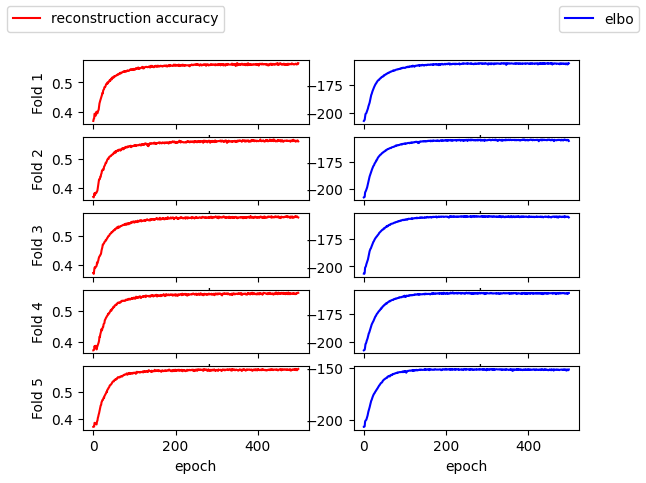

In [18]:
fig, axs = plt.subplots(5, 2, sharex = "all")
for k in range(K):
  axs[k,0].plot(valid_recon_accs[k+1][1:], label = "reconstruction accuracy", color = 'r')
  #plt.plot(test_loss_epoch, label = "test", color = 'b')
  #plt.ylim((140, 180))
  axs[k,0].set_xlabel('epoch')
  axs[k,0].set_ylabel(f"Fold {k+1}")
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels,loc = "upper left")

for k in range(K):
  axs[k,1].plot([x/batch_size for x in valid_elbos[k+1]][1:], label = "elbo", color = 'b')
  #plt.plot(test_loss_epoch, label = "test", color = 'b')
  #plt.ylim((140, 180))
  axs[k,1].set_xlabel('epoch')
handles, labels = axs[0,1].get_legend_handles_labels()
fig.legend(handles, labels,  loc = "upper right")
